In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mopet import mopet

from synchronization import plots
from synchronization import runner
from synchronization import analysis
from synchronization import processing
from synchronization import constants

# Replication of Meng et al. findings

Meng et al. setup for the 2 coupled network case:

* network with all-to-all coupling
* noisy-inputs to different neurons belonging to same or different network are uncorrelated
* IF neuron model
* input noise for a neuron is modeled as independent Poisson spike trains, mean rate is equal inside a network
* only inhibitory connections, gamma rhythm produced by ING mechanism
* local and global order parameter to measure synchrony

Observations
* with very weak noise: LFPs of different networks do not synchronize, they oscillate at different frequencies -> $r_{global}$ is small
* if noise increases at a certain point system jumps and global order parameter is significantly higher
* Reduction of noise leads now to increased desynchronization

Meng et al. main finding is that independent noise can lead to synchronization across two networks

## Model Configuration

The default parameters set the model in a state where high noise strength (13.0) synchronized the otherwise desynchronized networks 1 and 2.

In [2]:
params = {
  "runtime": 1000.0,

  "J_itoi": 5.0,
  "J_etoe": 0.6,
  "J_etoi": 3.2,
  "J_itoe": 7.0,

  "ou_enabled": [False, False],

  "poisson_enabled": [True, True],
  "poisson_variance": 13.0,
  "poisson_p": 0.7,
  "poisson_size": 800,
  "poisson_mean_input": 600,

   "J_ppee": 0.6,
   "J_ppei": 0.6,

   "const_delay": 0.2,
   "N_pop": 2
}

In [ ]:
model = runner.run(modified_params=params, file_name="meng-replication")

Initializing net ...
Net 1 - poisson rate 27692.30769230769 - single neuron 34.61538461538461
Poisson strength: 0.021666666666666667
Net 2 - rate for single neuron 24.230769230769226
Initialization time: 0.4931049346923828s
==== Running Network ... ====


In [3]:
if 'model' not in locals() or model is None:
    model = analysis.load_model("meng-replication")

## Model Visualization

### Power Spectral Density

We can see here peak activity in 40-60 Hz of both networks. Confirms gamma band activity.

As we have uncorrelated noise as input which leads to irregular firing, the frequency band is wide.

However density/bandpower of excitatory group is significantly lower than inhibitory group. Can this be explained by the sparse firing of E cells?
As only a fraction of E cells participate in each cycle of the PING rhythm compared to the regular firing of the inhibitory group.

(<Figure size 576x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x131296890>)

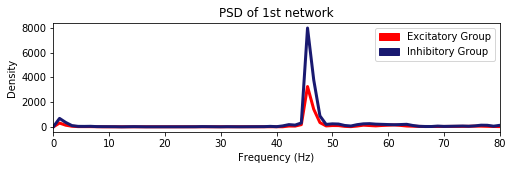

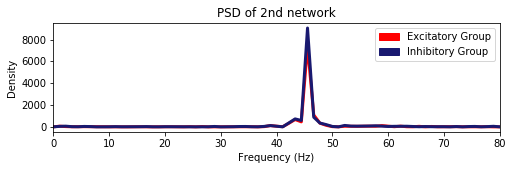

In [4]:
plots.psd(model, title="PSD of 1st network", population=1, fig_size=(8, 2), xlim=80)
plots.psd(model, title="PSD of 2nd network", population=2, fig_size=(8, 2), xlim=80)

### Local Field Potentials

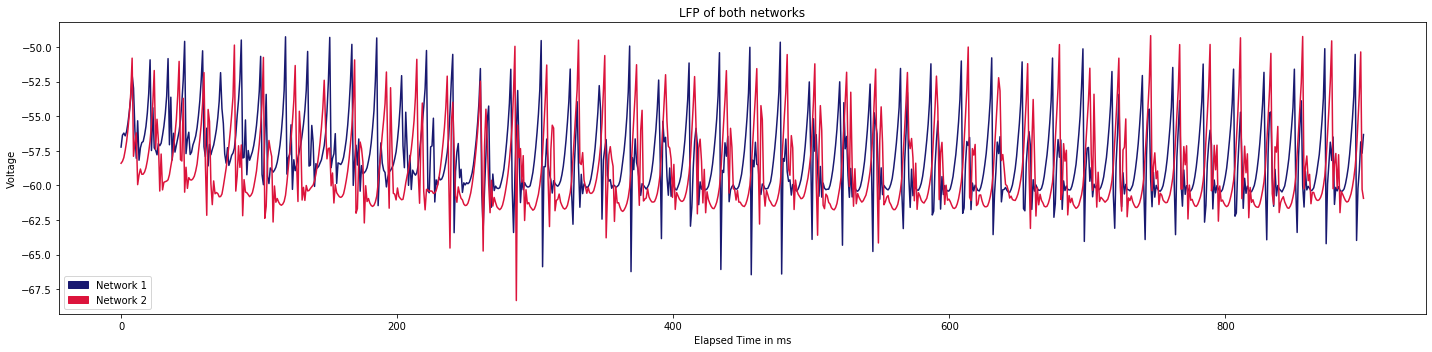

In [5]:
plots.lfp_nets(model, skip=100)

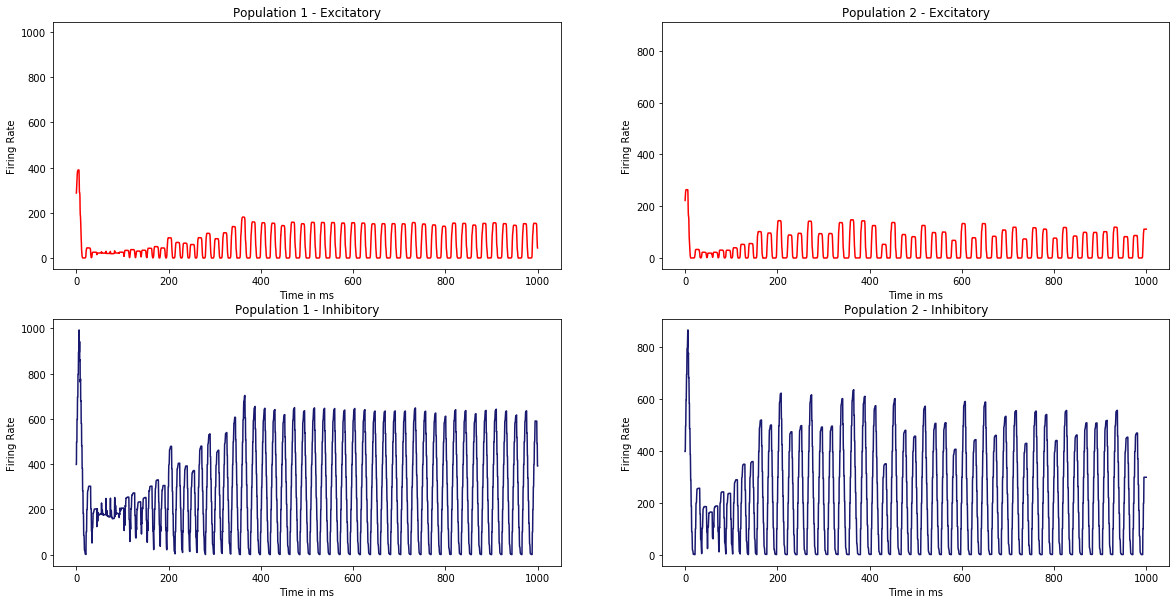

In [6]:
plots.population_rates(model)

(<Figure size 2160x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12e628850>)

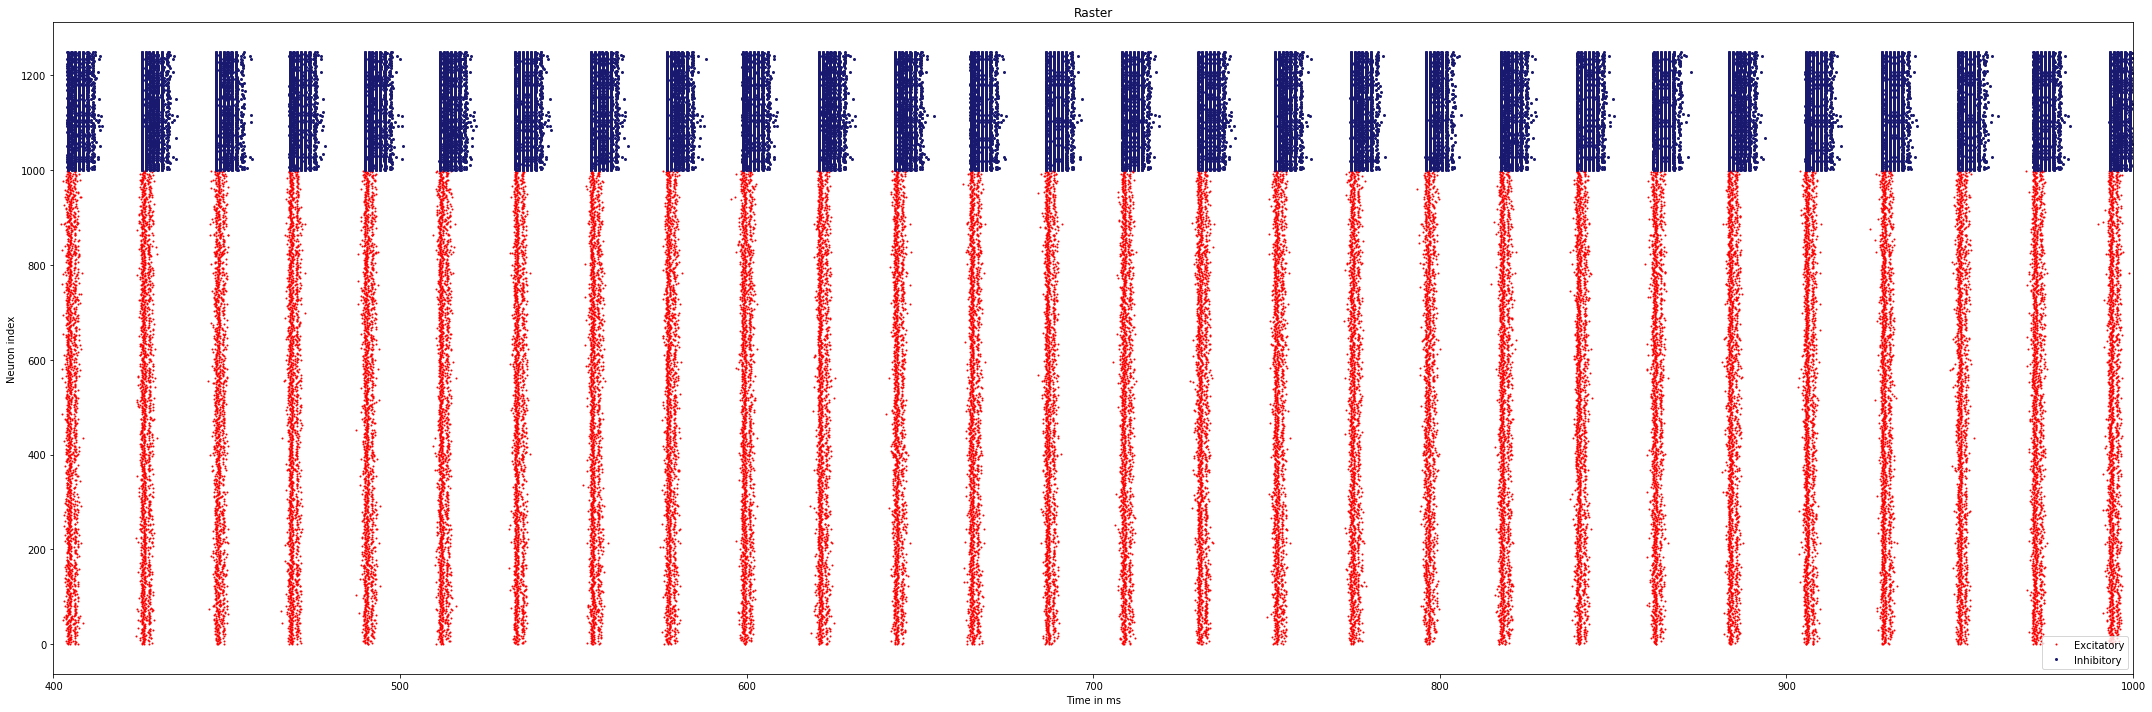

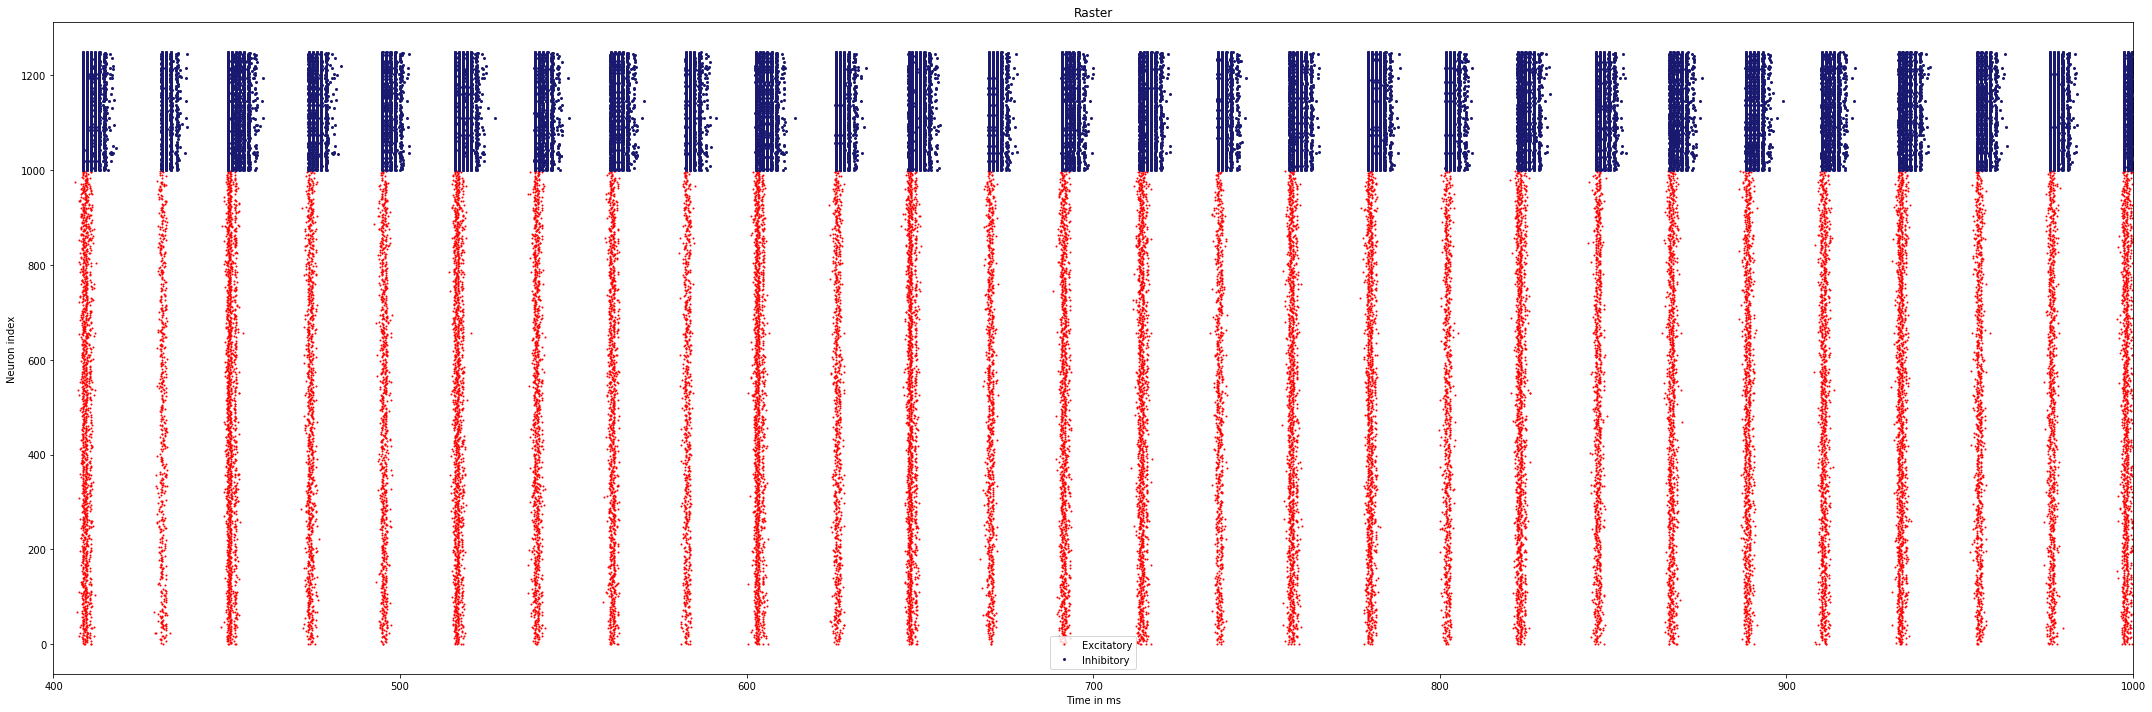

In [7]:
plots.raster(model, population=1, x_left=400, x_right=1000, fig_size=(30, 10))
plots.raster(model, population=2, x_left=400, x_right=1000, fig_size=(30, 10))

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12e7da410>)

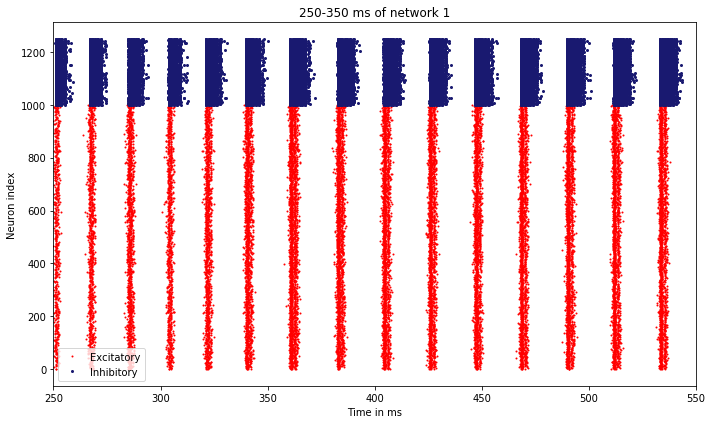

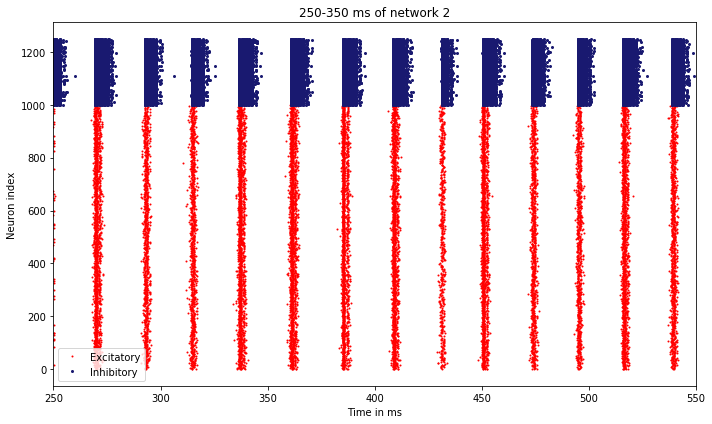

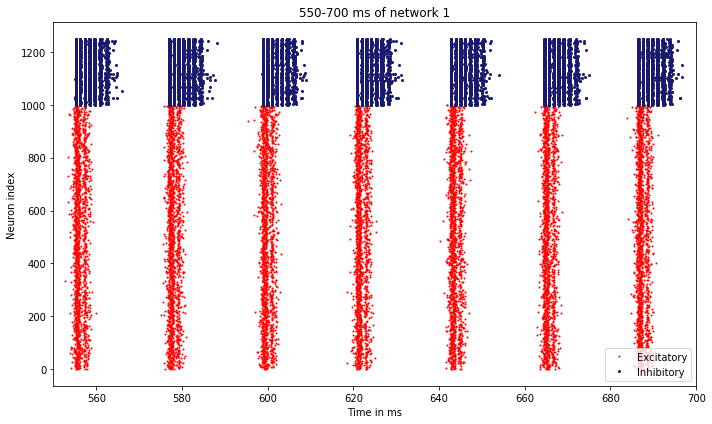

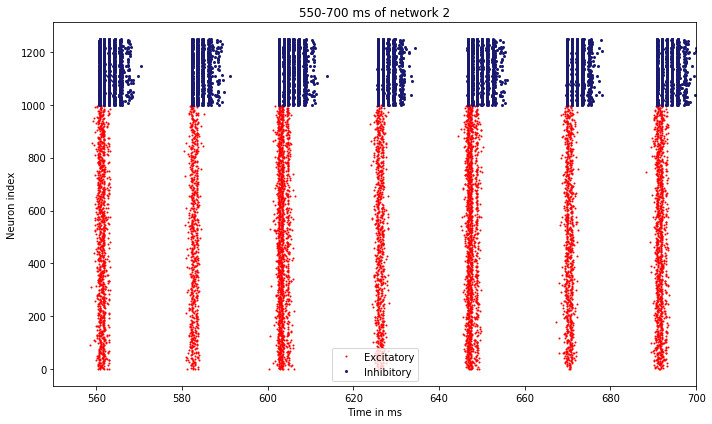

In [8]:
plots.raster(title="250-350 ms of network 1", model=model, x_left=250, x_right=550)
plots.raster(title="250-350 ms of network 2", model=model, x_left=250, x_right=550, population=2)

plots.raster(title="550-700 ms of network 1", model=model, x_left=550, x_right=700)
plots.raster(title="550-700 ms of network 2", model=model, x_left=550, x_right=700, population=2)

### Spike Variability of Excitatory Neurons

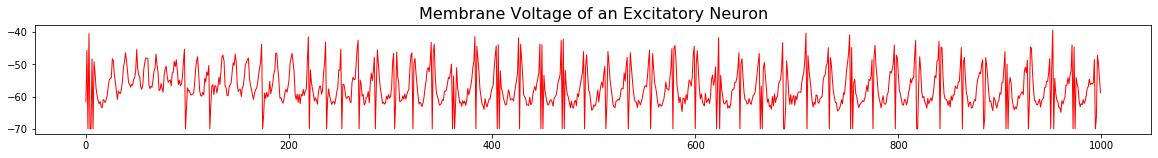

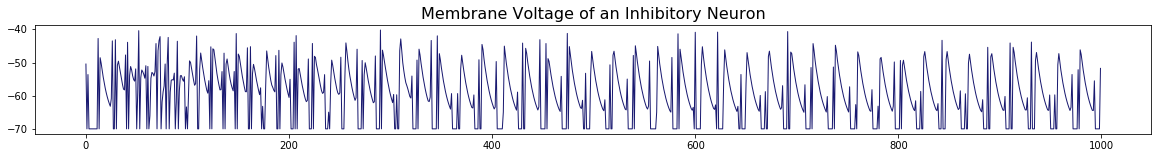

In [5]:
v = model["v_all_neurons_e"]
t = model["t_all_neurons_e"]

plt.figure(figsize=(20, 2))
plt.title("Membrane Voltage of an Excitatory Neuron", fontsize=16)
plt.plot(t, v[0], c=plots.c_exc, linewidth=1.0)

v = model["v_all_neurons_i1"]
t = model["t_all_neurons_i1"]

plt.figure(figsize=(20, 2))
plt.title("Membrane Voltage of an Inhibitory Neuron", fontsize=16)
plt.plot(t, v[0], c=plots.c_inh, linewidth=1.0)

## Synchronization Analysis

Meng et al. compute two different order parameters: The global order parameter and the local order parameter.

Considerations:
* Meng et al. mention that in the IF-model the voltage trace $V(t)$ does not include the action potential itself, therefore they add a spike of $45 mV$ manually.
Do we have the same case in our model?
* Meng et al. used only inhibitory connections and oscillations in the gamma band are caused by the ING mechanism. For a perfectly synchronized ING-rhythm we expect **all** neurons to fire in total synchrony. However, in PING we have an interplay between pyramidal neurons (excitatory) and interneurons (inhibitory). Thus, in a state of perfect synchrony we expect a small phase difference between the excitatory group and the ihibitory group. Considering this, the order parameter would never reach optimal value as we always have phase differences between the two groups. However, we could alter the order parameter by computing average phase synchronization for excitatory and inhibitory group seprately and then again use the average of both groups as measure for within-synchronization in the network.


### Across Network Phase Synchronization

Global Order Parameter value of: 0.7199315923879928
Mean Phase Coherence 0.96343521727578


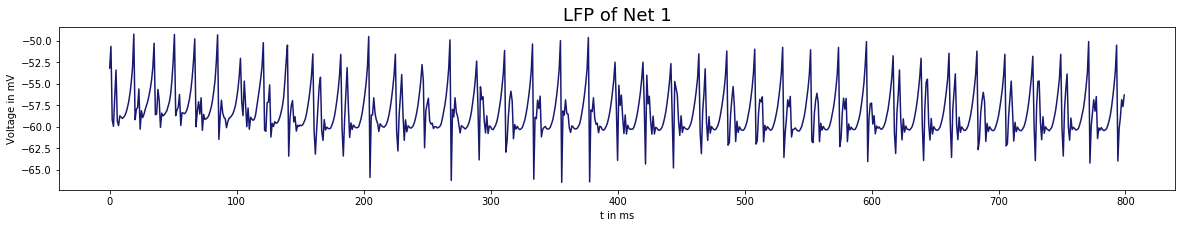

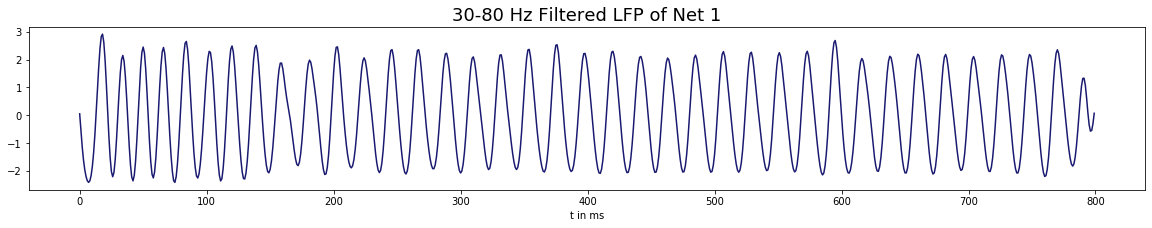

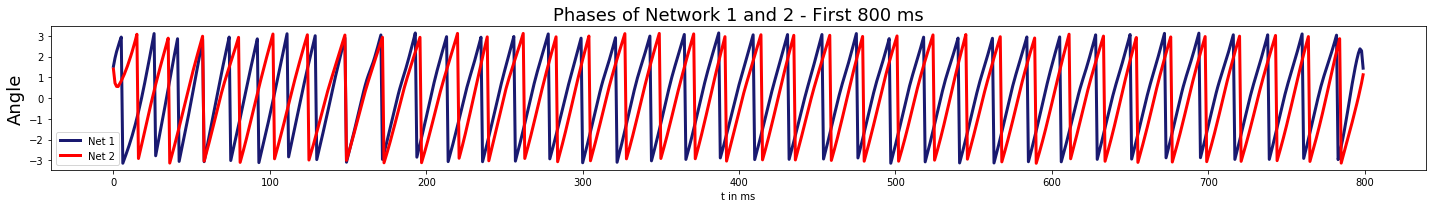

In [15]:
plots.phases_inter_nets(model)

### Within Phase Synchronization

Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.5760185216072188
Within Synchronization of Network 2 0.5903214219051028


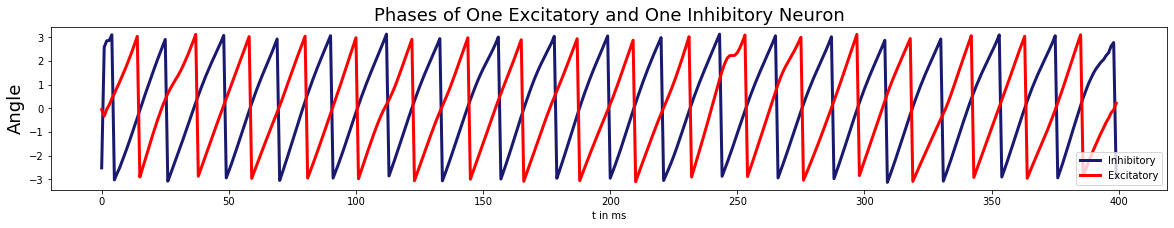

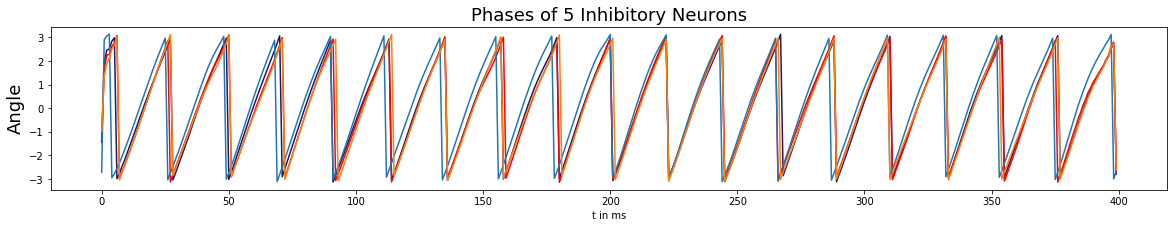

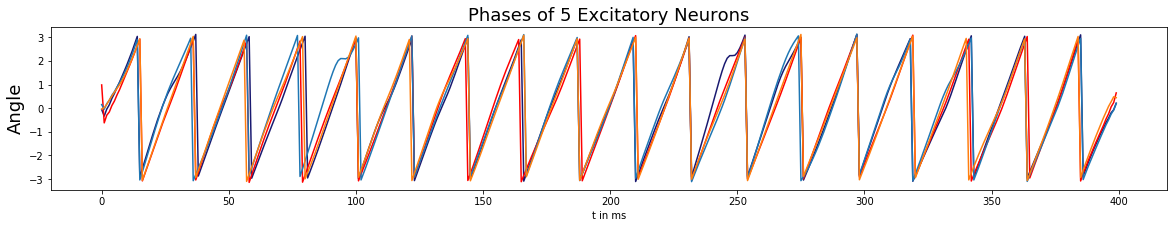

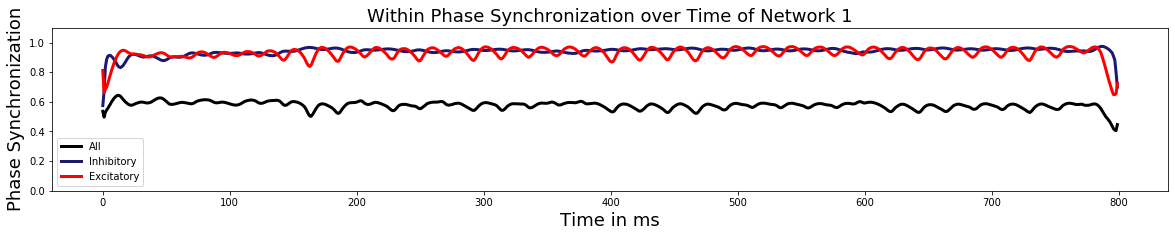

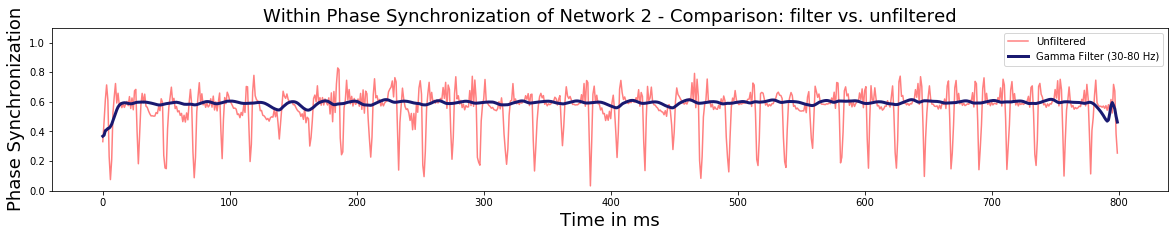

In [8]:
plots.phases_intra_nets(model)

NameError: name 'avg' is not defined

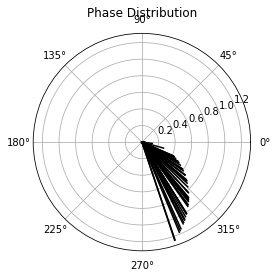

In [32]:
# TODO: fix this
# We want to plot here the average phase angle vectors of each neuron on the polar axis

phases = processing.phase(f_neurons_net_1)

plt.axes(polar=True)
plt.title("Phase Distribution")

for angle in phases[:50]:
    plt.plot((0, angle[10]), (0, np.abs(angle[10])), c="black")

# plot the average phase vector
# length of vector expresses the synchronization, [0-1].
plt.plot((0, avg[10]), (0, phi[10]), c='red')
plt.show()